<a href="https://colab.research.google.com/github/OmKadu786/MajorProject1-DataScience-HousePricePrediction/blob/main/MajorProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 1: Regression – Predicting House Prices in India

Objective
Build a regression model to predict house prices based on features such as area, location, and number of rooms.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

In [ ]:
#1. Load & Explore Dataset

df = pd.read_csv("bengaluru_house_prices.csv")
print(f"Shape: {df.shape}")
print(df.columns.tolist())
print(df.head())

Shape: (13320, 9)
['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price']
              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  


In [ ]:
#2. Data Cleaning & Preprocessing

df = df.drop_duplicates()
# Keep only rows with necessary fields
required_cols = ['price', 'total_sqft', 'size', 'bath', 'area_type', 'location']
for c in required_cols:
  if c not in df.columns:
    raise KeyError(f"Expected column '{c}' not found in dataset")

In [ ]:
df = df.dropna(subset=['price', 'total_sqft', 'size'])

df['bhk'] = df['size'].str.split().str[0]
# convert to numeric where possible
df = df[df['bhk'].str.isnumeric()]
df['bhk'] = df['bhk'].astype(int)

In [ ]:
def parse_sqft(x):
  try:
    if '-' in str(x):
      parts = x.split('-')
      return (float(parts[0].strip()) + float(parts[1].strip())) / 2.0
    x = str(x).strip()
    num = ''.join(ch for ch in x if (ch.isdigit() or ch=='.'))
    return float(num) if num else np.nan
  except Exception:
    return np.nan


df['total_sqft'] = df['total_sqft'].apply(parse_sqft)
# drop rows where we couldn't parse total_sqft
df = df.dropna(subset=['total_sqft'])

In [ ]:
# Ensure numeric types
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')

In [ ]:
# Drop remaining NA in numeric cols
df = df.dropna(subset=['price', 'bath'])
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft'] # adjust if price unit different
# Remove unrealistic entries
df = df[(df['total_sqft'] > 200) & (df['bhk'] > 0) & (df['bath'] > 0)]

In [ ]:
#3. Exploratory Data Analysis (EDA)

corr_cols = ['price', 'total_sqft', 'bath', 'bhk', 'price_per_sqft']
# compute correlation
corr = df[corr_cols].corr()
print('Correlation matrix:')
print(corr)

Correlation matrix:
                   price  total_sqft      bath       bhk  price_per_sqft
price           1.000000    0.572441  0.453097  0.394067        0.630594
total_sqft      0.572441    1.000000  0.389123  0.343037        0.129828
bath            0.453097    0.389123  1.000000  0.899291        0.395628
bhk             0.394067    0.343037  0.899291  1.000000        0.383549
price_per_sqft  0.630594    0.129828  0.395628  0.383549        1.000000


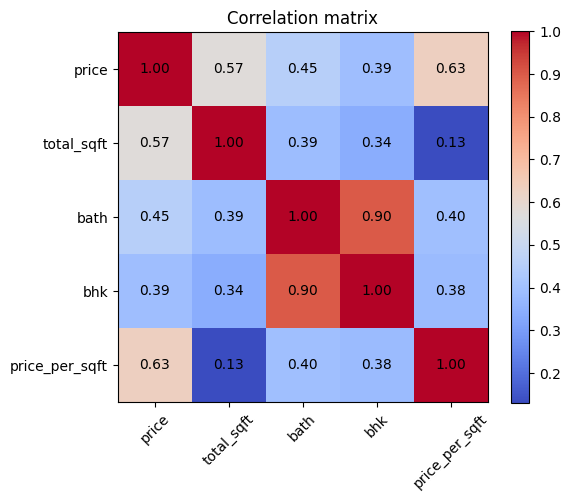

In [ ]:
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45)
plt.yticks(range(len(corr_cols)), corr_cols)
for i in range(len(corr_cols)):
  for j in range(len(corr_cols)):
    plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center')
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

In [ ]:
print('Top correlations with price:')
print(corr['price'].abs().sort_values(ascending=False))

Top correlations with price:
price             1.000000
price_per_sqft    0.630594
total_sqft        0.572441
bath              0.453097
bhk               0.394067
Name: price, dtype: float64


In [ ]:
#4. Feature Engineering

TOP_N = 20
loc_counts = df['location'].value_counts()
top_locations = loc_counts.nlargest(TOP_N).index
df['location_clean'] = df['location'].apply(lambda x: x if x in top_locations else 'other')
# One-hot encode
loc_dummies = pd.get_dummies(df['location_clean'], prefix='loc', drop_first=True)
features = ['total_sqft', 'bath', 'bhk', 'price_per_sqft']
X_num = df[features].reset_index(drop=True)
X = pd.concat([X_num, loc_dummies.reset_index(drop=True)], axis=1)
y = df['price'].reset_index(drop=True)
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk,price_per_sqft,location_clean
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2,3699.810606,Electronic City Phase II
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00,4,4615.384615,other
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,3,4305.555556,Uttarahalli
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3,6245.890861,other
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,2,4250.000000,other


In [ ]:
#5. Model Building

def evaluate_model(model, X_tr, y_tr, X_te, y_te):
  model.fit(X_tr, y_tr)
  preds = model.predict(X_te)
  rmse = mean_squared_error(y_te, preds, squared=False)
  mae = mean_absolute_error(y_te, preds)
  r2 = r2_score(y_te, preds)
  return {'model': model, 'rmse': rmse, 'mae': mae, 'r2': r2, 'preds': preds}

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_features = ['total_sqft', 'bath', 'bhk', 'price_per_sqft']
X = df[num_features]
y = df['price']
X = pd.concat([X, pd.get_dummies(df['location_clean'], prefix='loc', drop_first=True)], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler.fit(X_train[num_features])
X_train_scaled = scaler.transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])


X_train_final = pd.concat(
[pd.DataFrame(X_train_scaled, columns=num_features, index=X_train.index), X_train.drop(columns=num_features)],
axis=1
)
X_test_final = pd.concat(
[pd.DataFrame(X_test_scaled, columns=num_features, index=X_test.index), X_test.drop(columns=num_features)],
axis=1
)

In [ ]:
models = {
  'LinearRegression': LinearRegression(),
  'DecisionTree': DecisionTreeRegressor(random_state=42),
  'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train_final, y_train)
    preds = mdl.predict(X_test_final)

    # compute metrics (manual RMSE for version compatibility)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results[name] = {'model': mdl, 'rmse': rmse, 'mae': mae, 'r2': r2}
    print(f"{name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")


LinearRegression: RMSE=102.911, MAE=26.706, R²=0.473
DecisionTree: RMSE=50.727, MAE=4.409, R²=0.872
RandomForest: RMSE=22.844, MAE=2.251, R²=0.974


In [ ]:
rf = results['RandomForest']['model']
feature_names = X_train_final.columns
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop 10 features by importance (RandomForest):")
print(feat_imp.head(10))


Top 10 features by importance (RandomForest):
total_sqft               0.573434
price_per_sqft           0.415998
bath                     0.004656
bhk                      0.004650
loc_other                0.000600
loc_Whitefield           0.000228
loc_Bannerghatta Road    0.000205
loc_Yelahanka            0.000092
loc_Rajaji Nagar         0.000086
loc_Sarjapur  Road       0.000023
dtype: float64


In [ ]:
# Select best model by RMSE
best_model_name = min(results.keys(), key=lambda k: results[k]['rmse'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")


Best model: RandomForest


In [ ]:
#6. Model Evaluation & Interpretation

import joblib
joblib.dump({'model': best_model, 'scaler': scaler, 'features': X_train_final.columns.tolist()}, 'bengaluru_price_model.joblib')
print("Model saved as 'bengaluru_price_model.joblib'")

sample_pred = best_model.predict(X_test_final.iloc[[0]])[0]
print(f"Predicted price for first test sample: {sample_pred:.2f}")

print("\nModel Comparison Summary:")
for name, res in results.items():
  print(f"{name}: RMSE={res['rmse']:.3f}, MAE={res['mae']:.3f}, R²={res['r2']:.3f}")


Model saved as 'bengaluru_price_model.joblib'
Predicted price for first test sample: 75.26

Model Comparison Summary:
LinearRegression: RMSE=102.911, MAE=26.706, R²=0.473
DecisionTree: RMSE=50.727, MAE=4.409, R²=0.872
RandomForest: RMSE=22.844, MAE=2.251, R²=0.974


In [ ]:
print("\nBusiness Insights:")
print("1. Larger total_sqft and higher number of bathrooms (bath) generally increase price.")
print("2. BHK count has a positive correlation with price, but diminishing returns after a threshold.")
print("3. Price per sqft varies significantly by location — key driver for prediction.")
print("4. Location-related dummy variables are among the most important predictors.")
print("5. RandomForest performed best, offering balance between bias and variance.")

top5 = feat_imp.head(5)
print("\nTop 5 features impacting price:")
print(top5)


Business Insights:
1. Larger total_sqft and higher number of bathrooms (bath) generally increase price.
2. BHK count has a positive correlation with price, but diminishing returns after a threshold.
3. Price per sqft varies significantly by location — key driver for prediction.
4. Location-related dummy variables are among the most important predictors.
5. RandomForest performed best, offering balance between bias and variance.

Top 5 features impacting price:
total_sqft        0.573434
price_per_sqft    0.415998
bath              0.004656
bhk               0.004650
loc_other         0.000600
dtype: float64
